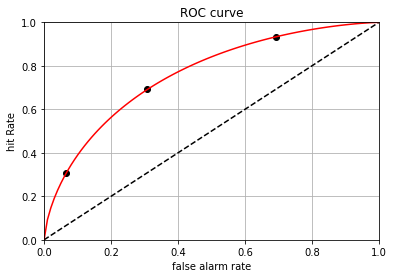

...........
----------------------------------------------------------------------
Ran 11 tests in 0.097s

OK


In [56]:
import numpy as np
import scipy as spi
import unittest
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt


class SignalDetection:
    def __init__(self, hits, misses, falseAlarms, correctRejections):
        self.hits = hits
        self.misses = misses
        self.falseAlarms = falseAlarms
        self.correctRejections = correctRejections

    def hitRate(self):
        return(self.hits/(self.hits + self.misses))
    
    def falseAlarmrate(self):
        return(self.falseAlarms/(self.falseAlarms+ self.correctRejections))
        
    def d_prime(self):
        return (norm.ppf(self.hitRate()) - norm.ppf(self.falseAlarmrate()))

    def criterion(self):
        return -0.5 * (norm.ppf(self.hitRate()) + norm.ppf(self.falseAlarmrate()))
   #Add Overloading Operators 
    def __add__(self,other):
        return SignalDetection(self.hits + other.hits, self.misses + other.misses, 
        self.falseAlarms + other.falseAlarms, self.correctRejections + other.correctRejections)
    
    def __mul__(self,scalar):
        return SignalDetection( self.hits * scalar, self.misses * scalar, self.falseAlarms * scalar,
        self.correctRejections * scalar)
        
    def nLogLikelihood(self, hitRate, falseAlarmrate):
        return -((self.hits * np.log(hitRate)) + (self.misses * np.log(1-hitRate)) + (self.falseAlarms * np.log(falseAlarmrate)) + (self.correctRejections * np.log(1-falseAlarmrate)))
    
    @staticmethod
    def simulate(dprime, criteriaList, signalCount, noiseCount):
        hitRates = norm.cdf((dprime - 2 * np.array(criteriaList)) / 2)
        falseAlarmRates = norm.cdf((- dprime - 2 * np.array(criteriaList)) / 2)
        sdtList = [SignalDetection(np.random.binomial(signalCount, hitRates[i]), np.random.binomial(signalCount, 1 - hitRates[i]), 
        np.random.binomial(noiseCount, falseAlarmRates[i]), np.random.binomial(noiseCount, 1 - falseAlarmRates[i])) for i in range(len(criteriaList))]
        return sdtList
    
    @staticmethod
    def plot_roc(sdtList):
        fig, ax = plt.subplots()
        ax.set(xlim=[0, 1], ylim=[0, 1], xlabel="false alarm rate", ylabel="hit Rate",
           title="ROC curve")
        ax.plot(np.linspace(0, 2, 80), np.linspace(0, 2, 80), '--', color='black')
        for sdt in sdtList:
            ax.plot(sdt.falseAlarmrate(), sdt.hitRate(), 'o', color='black')
            ax.grid()

    @staticmethod
    def rocCurve(falseAlarmrate, a):
        hitRate = norm.ppf(falseAlarmrate)
        return norm.cdf(a + hitRate)

    @staticmethod
    def fit_roc(sdtList):
        SignalDetection.plot_roc(sdtList)
        res = minimize_scalar(SignalDetection.rocLoss, method='bounded', bounds=[0, 1], args=(sdtList,))
        a_hat = res.x
        t = np.linspace(0, 1, 100)
        loss = SignalDetection.rocCurve(t, a_hat)
        plt.plot(t, loss, '-', color='r')
        return float(a_hat)

    @staticmethod
    def rocLoss(a, sdtList):
        return sum([sdt.nLogLikelihood(sdt.rocCurve(sdt.falseAlarmrate(), a), sdt.falseAlarmrate()) for sdt in sdtList])


sdtList = SignalDetection.simulate(1, [-1, 0, 1], 1e7, 1e7)
SignalDetection.fit_roc(sdtList)
plt.show()
    
class TestSignalDetection(unittest.TestCase):
    """
    Test suite for SignalDetection class.
    """

    def test_d_prime_zero(self):
        """
        Test d-prime calculation when hits and false alarms are 0.
        """
        sd   = SignalDetection(15, 5, 15, 5)
        expected = 0
        obtained = sd.d_prime()
        self.assertAlmostEqual(obtained, expected, places=10)

    def test_d_prime_nonzero(self):
        """
        Test d-prime calculation when hits and false alarms are nonzero.
        """
        sd   = SignalDetection(15, 10, 15, 5)
        expected = -0.421142647060282
        obtained = sd.d_prime()
        self.assertAlmostEqual(obtained, expected, places=10)

    def test_criterion_zero(self):
        """
        Test criterion calculation when hits and false alarms are both 0.
        """
        sd   = SignalDetection(5, 5, 5, 5)
        expected = 0
        obtained = sd.criterion()
        self.assertAlmostEqual(obtained, expected, places=10)

    def test_criterion_nonzero(self):
        """
        Test criterion calculation when hits and false alarms are nonzero.
        """
        sd   = SignalDetection(15, 10, 15, 5)
        expected = -0.463918426665941
        obtained = sd.criterion()
        self.assertAlmostEqual(obtained, expected, places=10)

    def test_addition(self):
        """
        Test addition of two SignalDetection objects.
        """
        sd = SignalDetection(1, 1, 2, 1) + SignalDetection(2, 1, 1, 3)
        expected = SignalDetection(3, 2, 3, 4).criterion()
        obtained = sd.criterion()
        self.assertEqual(obtained, expected)

    def test_multiplication(self):
        """
        Test multiplication of a SignalDetection object with a scalar.
        """
        sd = SignalDetection(1, 2, 3, 1) * 4
        expected = SignalDetection(4, 8, 12, 4).criterion()
        obtained = sd.criterion()
        self.assertEqual(obtained, expected)

    def test_simulate_single_criterion(self):
        """
        Test SignalDetection.simulate method with a single criterion value.
        """
        dPrime       = 1.5
        criteriaList = [0]
        signalCount  = 1000
        noiseCount   = 1000
        
        sdtList      = SignalDetection.simulate(dPrime, criteriaList, signalCount, noiseCount)
        self.assertEqual(len(sdtList), 1)
        sdt = sdtList[0]
        
        self.assertEqual(sdt.hits             , sdtList[0].hits)
        self.assertEqual(sdt.misses           , sdtList[0].misses)
        self.assertEqual(sdt.falseAlarms      , sdtList[0].falseAlarms)
        self.assertEqual(sdt.correctRejections, sdtList[0].correctRejections)

    def test_simulate_multiple_criteria(self):
        """
        Test SignalDetection.simulate method with multiple criterion values.
        """
        dPrime       = 1.5
        criteriaList = [-0.5, 0, 0.5]
        signalCount  = 1000
        noiseCount   = 1000
        sdtList      = SignalDetection.simulate(dPrime, criteriaList, signalCount, noiseCount)
        self.assertEqual(len(sdtList), 3)
        for sdt in sdtList:
            self.assertLessEqual (sdt.hits              ,  signalCount)
            self.assertLessEqual (sdt.misses            ,  signalCount)
            self.assertLessEqual (sdt.falseAlarms       ,  noiseCount)
            self.assertLessEqual (sdt.correctRejections ,  noiseCount)

    def test_nLogLikelihood(self):
        """
        Test case to verify nLogLikelihood calculation for a SignalDetection object.
        """
        sdt = SignalDetection(10, 5, 3, 12)
        hit_rate = 0.5
        false_alarm_rate = 0.2
        expected_nll = - (10 * np.log(hit_rate) +
                           5 * np.log(1-hit_rate) +
                           3 * np.log(false_alarm_rate) +
                          12 * np.log(1-false_alarm_rate))
        self.assertAlmostEqual(sdt.nLogLikelihood(hit_rate, false_alarm_rate),
                               expected_nll, places=6)

    def test_rocLoss(self):
        """
        Test case to verify rocLoss calculation for a list of SignalDetection objects.
        """
        sdtList = [
            SignalDetection( 8, 2, 1, 9),
            SignalDetection(14, 1, 2, 8),
            SignalDetection(10, 3, 1, 9),
            SignalDetection(11, 2, 2, 8),
        ]
        a = 0
        expected = 99.3884
        self.assertAlmostEqual(SignalDetection.rocLoss(a, sdtList), expected, places=4)
        
    def test_integration(self):
        """
        Test case to verify integration of SignalDetection simulation and ROC fitting.
        """
        dPrime  = 1
        sdtList = SignalDetection.simulate(dPrime, [-1, 0, 1], 1e7, 1e7)
        aHat    = SignalDetection.fit_roc(sdtList)
        self.assertAlmostEqual(aHat, dPrime, places=2)
        plt.close()

if __name__ == '__main__':
    unittest.main(argv=['ignored'], exit=False)

